# HW3. MLP 신경망 성능에 영향을 주는 요소별 실험과 분석

> 2020069052 윤후성

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import  load_digits, make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set device to GPU if available, otherwise CPU
print(f"Using device: {device}")

Using device: cuda


## 공통으로 사용될 MLP 구조

In [2]:
class MLP(nn.Module): # MLP 모델 정의
    def __init__(self, input_size, hidden_sizes, num_classes, activation=nn.ReLU):
        super().__init__()
        layers = []
        in_dim = input_size
        self.hidden_layer_indices = []

        # 은닉층: Linear → Activation
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation())
            # 방금 추가한 Activation 모듈의 인덱스 저장
            self.hidden_layer_indices.append(len(layers) - 1)
            in_dim = h

        # 출력층
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

        # 
        # 입력을 한 번에 펼쳐주는 레이어
        self.flatten = lambda x: x.view(x.size(0), -1)

        # Weight 초기화 (std=0.01, bias=0)
        # for m in self.net:
        #     if isinstance(m, nn.Linear):
        #         nn.init.normal_(m.weight, mean=0.0, std=0.01)
        #         nn.init.zeros_(m.bias)

    def forward(self, x, return_activations=False):
        # 1) 입력 펼치기
        out = self.flatten(x)

        acts = []
        # 2) Sequential 순회하며 activation 추출
        for idx, layer in enumerate(self.net):
            out = layer(out)
            if return_activations and idx in self.hidden_layer_indices:
                acts.append(out)

        # 3) 반환
        if return_activations:
            # (logits, [act1, act2, ...])
            return out, acts
        return out

### Parameter

In [3]:
batch_size = 64
hidden_sizes = [256, 128]  # Two hidden layers

input_size = 64  # A: 8x8 images flattened
num_classes = 10  # Digits 0-9
epochs = 30

# input_size = 2  # A: 8x8 images flattened
# num_classes = 2  # Digits 0-9
# epochs = 200

### 데이터 로드, 데이터셋 생성
- Digit Dataset(scikit-learn) - 8 x 8 숫자 이미지

In [4]:
# 실험 A, C
digits = load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.int64))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.int64))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# # 실험 B
# X, y = make_circles(n_samples=1000, noise=0.1, factor=0.4, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train)),
#                           batch_size=32, shuffle=True)
# test_loader  = DataLoader(TensorDataset(torch.Tensor(X_test),  torch.LongTensor(y_test)),
#                           batch_size=32)

### 실험별, config 설정

In [5]:
config = [
    {
        'loss_fn': nn.CrossEntropyLoss(),
        'activation': nn.ReLU,
        'optimizer': optim.SGD,
        'lr': 0.001,
        'momentum': 0
    },
    {
        'loss_fn': nn.CrossEntropyLoss(),
        'activation': nn.ReLU,
        'optimizer': optim.SGD,
        'lr': 0.001,
        'momentum': 0.9,
    },
    # {
    #     'loss_fn': nn.CrossEntropyLoss(),
    #     'activation': nn.ReLU,
    #     'optimizer': optim.Adam,
    #     'lr': 0.001,
    #     'momentum': 0
    # }
]


### 학습

In [ ]:
history = [[] for _ in range(len(config))]

# Training loop
for i, config_item in enumerate(config):
    # i = 2
    loss_fn = config_item['loss_fn']
    activation = config_item['activation']
    optimizer = config_item['optimizer']
    lr = config_item['lr']
    momentum = config_item.get('momentum', 0)

    # Same Model configuration
    model = MLP(
        input_size, 
        hidden_sizes=hidden_sizes, 
        num_classes=num_classes, 
        activation=activation).to(device)
    
    # OPTIMIZER
    optimizer = optimizer(model.parameters(), lr=lr, momentum=momentum)
    # optimizer = optimizer(model.parameters(), lr=lr)
    
    # 실험 C: learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    for epoch in range(1, epochs+1):
        # train
        model.train()
        train_loss = train_correct = 0
        grad_norms_epoch = []

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb.view(Xb.size(0), -1))
            
            optimizer.zero_grad()
            # 실험 A: MSELoss
            if isinstance(loss_fn, torch.nn.MSELoss):
                probs = torch.softmax(logits, dim=1)
                y_onehot = torch.nn.functional.one_hot(yb, num_classes=probs.size(1)).float()
                loss = loss_fn(probs, y_onehot)
            else:
                # CrossEntropyLoss
                loss = loss_fn(logits, yb)
            
            loss.backward()

            # gradient norms 저장
            grad_norms_epoch.append([
                param.grad.norm().item()
                for name, param in model.named_parameters() 
                if 'weight' in name
            ])

            optimizer.step()
            
            train_loss += loss.item() * Xb.size(0)
            train_correct += (logits.argmax(dim=1) == yb).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        # test
        test_loss = 0.0
        test_correct = 0

        activations_epoch = []
        layer_dead_sum  = None
        layer_total_num = None

        with torch.no_grad():
            for Xb, yb in test_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                logits, acts = model(
                    Xb.view(Xb.size(0), -1),
                    return_activations=True
                )

                # loss 계산
                if isinstance(loss_fn, torch.nn.MSELoss):
                    probs = logits.softmax(dim=1)
                    y_onehot = torch.nn.functional.one_hot(
                        yb, num_classes=probs.size(1)
                    ).float()
                    loss = loss_fn(probs, y_onehot)
                else:
                    loss = loss_fn(logits, yb)

                test_loss   += loss.item() * Xb.size(0)
                test_correct+= (logits.argmax(1) == yb).sum().item()

                # 첫 배치에서 레이어 수만큼 리스트 초기화
                if layer_dead_sum is None:
                    n_layers = len(acts)
                    layer_dead_sum  = [0.0] * n_layers
                    layer_total_num = [0]   * n_layers

                # 레이어별 Dead ReLU 개수 누적, activation 저장
                for l, act in enumerate(acts):
                    flat = act.cpu().numpy().flatten()
                    activations_epoch.append(flat)
                    layer_dead_sum[l]  += (flat == 0).sum()
                    layer_total_num[l] += flat.size

        # 평균 loss/accuracy 계산
        test_loss /= len(test_loader.dataset)
        test_acc  = test_correct / len(test_loader.dataset)

        # 레이어별 평균 Dead ReLU 비율
        dead_ratios = [
            dead/total for dead, total in zip(
                layer_dead_sum, layer_total_num)
        ]

        # history에 저장
        history[i].append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'test_loss': test_loss,
            'test_acc': test_acc,
            'grad_norms': np.array(grad_norms_epoch),  # (batches, n_layers)
            'activations': activations_epoch,          # list of 1D arrays
            'dead_relu': dead_ratios                   # length = n_layers
        })

        print(f"Config {i+1} — Epoch {epoch}/{epochs}  "
              f"train_loss={train_loss:.3f}, train_acc={train_acc:.3f}, "
              f"test_loss={test_loss:.3f}, test_acc={test_acc:.3f},"
              f" dead_relu={dead_ratios}")

    # 요약 출력
    print(f"Finished training config {i+1}")
    print(f"Final Test Acc: {test_acc:.2f}\n")
    print(f"Minimum Test Loss: {min([h['test_loss'] for h in history[i]]):.4f}, ")
    final_dead_ratio = np.mean(history[i][-1]['dead_relu'])
    print(f"Final Dead ReLU Ratio: {final_dead_ratio:.4f}")

Config 1 — Epoch 1/30  train_loss=2.284, train_acc=0.158, test_loss=2.202, test_acc=0.181, dead_relu=[np.float64(0.4860568576388889), np.float64(0.5011935763888888)]
Config 1 — Epoch 2/30  train_loss=2.075, train_acc=0.318, test_loss=2.020, test_acc=0.372, dead_relu=[np.float64(0.48577473958333334), np.float64(0.49090711805555554)]
Config 1 — Epoch 3/30  train_loss=1.906, train_acc=0.460, test_loss=1.859, test_acc=0.500, dead_relu=[np.float64(0.4854600694444444), np.float64(0.4816840277777778)]
Config 1 — Epoch 4/30  train_loss=1.750, train_acc=0.593, test_loss=1.714, test_acc=0.636, dead_relu=[np.float64(0.4843532986111111), np.float64(0.47411024305555555)]
Config 1 — Epoch 5/30  train_loss=1.610, train_acc=0.695, test_loss=1.574, test_acc=0.728, dead_relu=[np.float64(0.4834743923611111), np.float64(0.4687717013888889)]
Config 1 — Epoch 6/30  train_loss=1.482, train_acc=0.763, test_loss=1.455, test_acc=0.789, dead_relu=[np.float64(0.48233506944444443), np.float64(0.4619357638888889)]


### 시각화

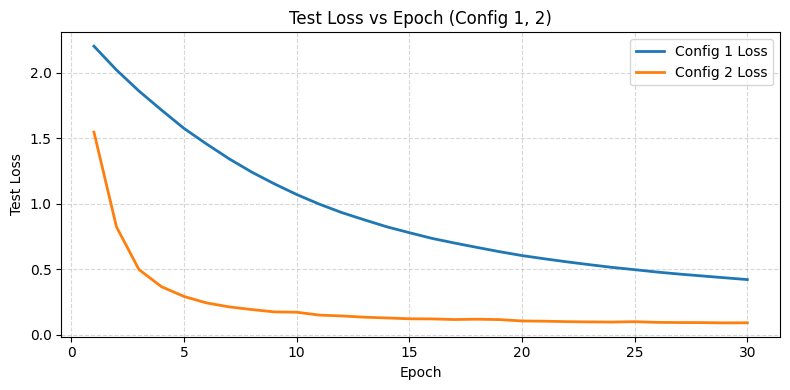

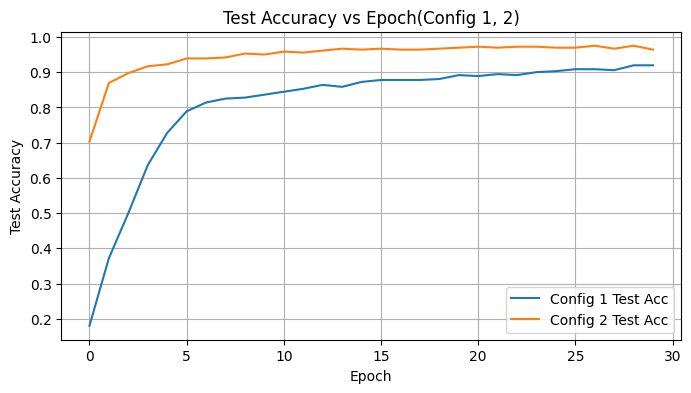

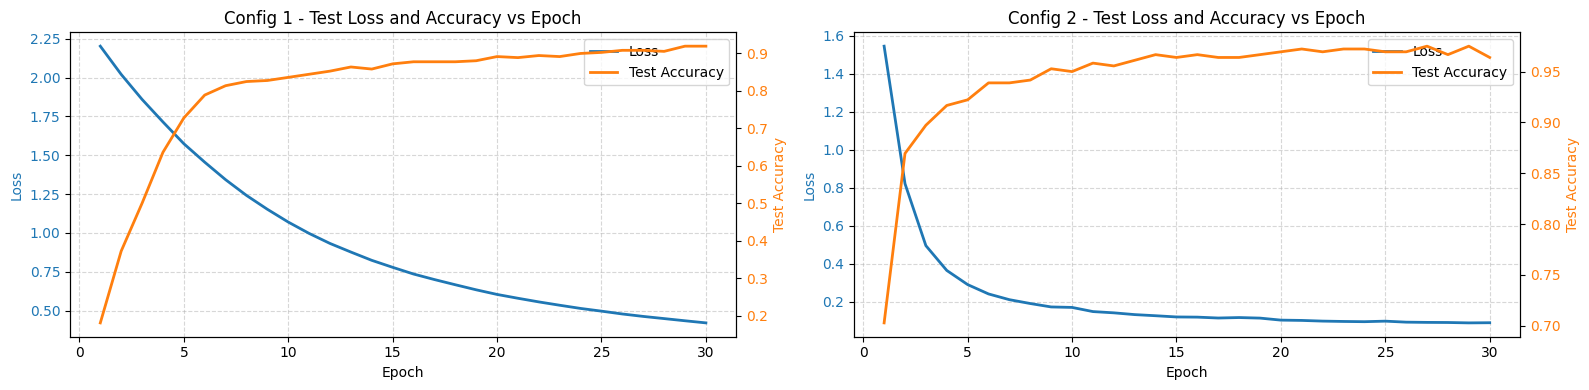

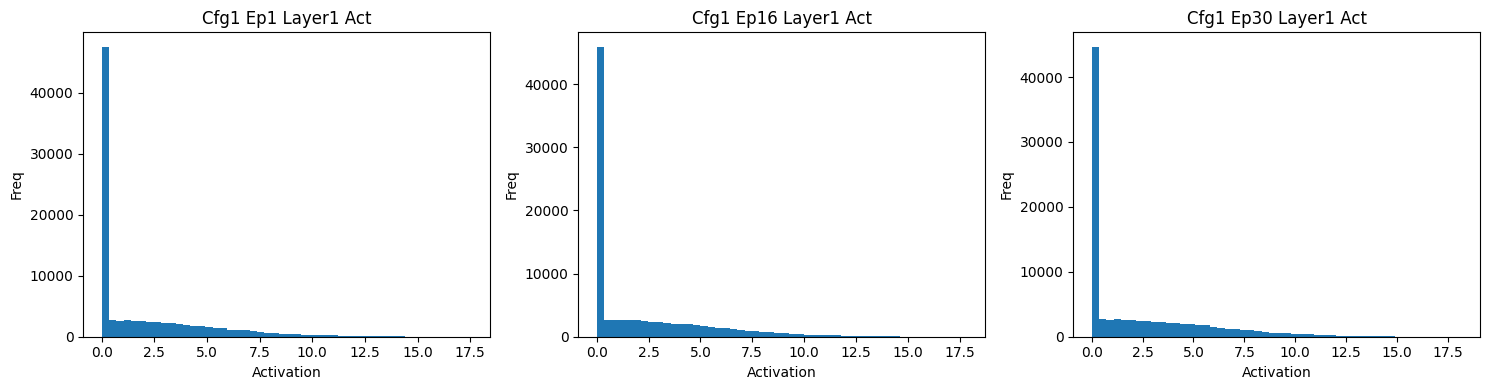

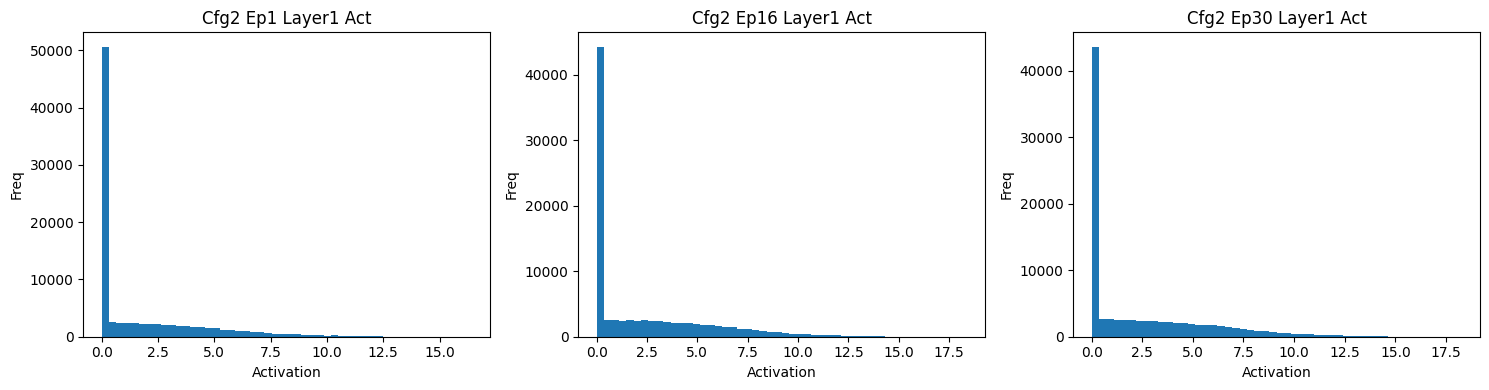

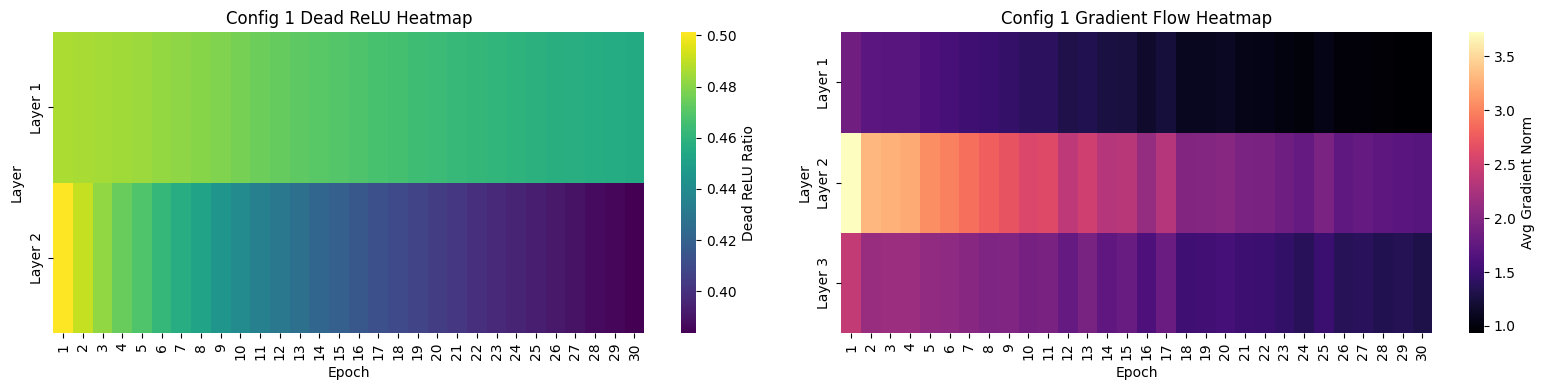

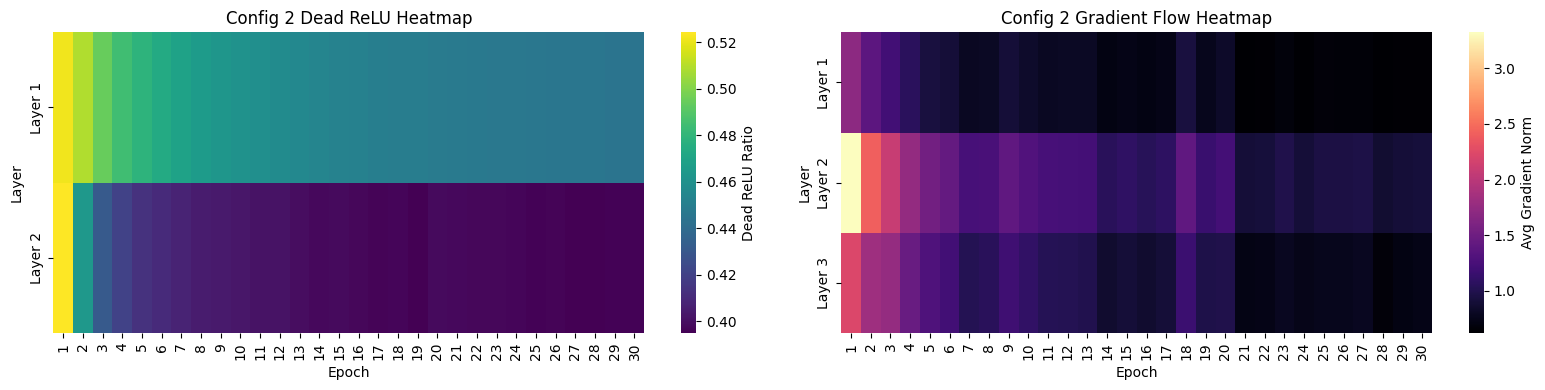

In [ ]:
n_configs = len(history)
n_layers = len(history[0][0]['dead_relu'])
epochs = len(history[0])


# 1. Test Loss vs Epoch
fig, ax1 = plt.subplots(figsize=(8, 4))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(n_configs):
    losses = [h['test_loss'] for h in history[i]]
    ax1.plot(range(1, len(losses)+1), losses, label=f'Config {i+1} Loss', color=colors[i % len(colors)], linewidth=2)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Loss')
ax1.legend(loc='upper right')
plt.title('Test Loss vs Epoch (Config 1, 2)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Accuracy vs Epoch
plt.figure(figsize=(8, 4))
for i in range(n_configs):
    test_accs = [h['test_acc'] for h in history[i]]
    plt.plot(test_accs, label=f'Config {i+1} Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Epoch(Config 1, 2)')
plt.legend()
plt.grid(True)
plt.show()

# 3. Test Loss and Accuracy vs Epoch
fig, axes = plt.subplots(1, n_configs, figsize=(8 * n_configs, 4), sharey=False)
if n_configs == 1:
    axes = [axes]
for i in range(n_configs):
    ce_losses = [h['test_loss'] for h in history[i]]
    test_accs = [h['test_acc'] for h in history[i]]
    epochs = range(1, len(ce_losses) + 1)

    ax1 = axes[i]
    color_ce = 'tab:blue'
    ax1.plot(epochs, ce_losses, label='Loss', color=color_ce, linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color_ce)
    ax1.tick_params(axis='y', labelcolor=color_ce)

    ax2 = ax1.twinx()
    color_acc = 'tab:orange'
    ax2.plot(epochs, test_accs, label='Test Accuracy', color=color_acc, linewidth=2)
    ax2.set_ylabel('Test Accuracy', color=color_acc)
    ax2.tick_params(axis='y', labelcolor=color_acc)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    ax1.set_title(f'Config {i+1} - Test Loss and Accuracy vs Epoch')
    ax1.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 3. Activation Histograms at selected epochs
selected = [0, len(ce_losses)//2, len(ce_losses)-1]
for i in range(n_configs):
    fig, axes = plt.subplots(1, len(selected), figsize=(15, 4))
    for j, e in enumerate(selected):
        acts = history[i][e]['activations']

        layer_acts = [np.concatenate(acts[k::n_layers]) for k in range(n_layers)]
        axes[j].hist(layer_acts[0], bins=50)
        axes[j].set_title(f'Cfg{i+1} Ep{e+1} Layer1 Act')
        axes[j].set_xlabel('Activation')
        axes[j].set_ylabel('Freq')
    plt.tight_layout()
    plt.show()

# 4. Dead ReLU & Gradient Flow Heatmap
import seaborn as sns

for i in range(n_configs):
    dead = np.array([h['dead_relu'] for h in history[i]]) 
    dead = dead.T  
    grad_means = np.array([
        np.mean(h['grad_norms'], axis=0)
        for h in history[i]
    ]).T  

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    
    # Dead ReLU Heatmap
    sns.heatmap(
        dead,
        ax=axes[0],
        xticklabels=np.arange(1, dead.shape[1]+1),
        yticklabels=[f'Layer {l+1}' for l in range(dead.shape[0])],
        cmap='viridis',
        cbar_kws={'label':'Dead ReLU Ratio'}
    )
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Layer')
    axes[0].set_title(f'Config {i+1} Dead ReLU Heatmap')

    # Gradient Flow Heatmap
    sns.heatmap(
        grad_means,
        ax=axes[1],
        xticklabels=np.arange(1, grad_means.shape[1]+1),
        yticklabels=[f'Layer {l+1}' for l in range(grad_means.shape[0])],
        cmap='magma',
        cbar_kws={'label':'Avg Gradient Norm'},
        annot=False,
        fmt=".2f"
    )
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Layer')
    axes[1].set_title(f'Config {i+1} Gradient Flow Heatmap')

    plt.tight_layout()
    plt.show()
